# Pneumonia Detection from Chest X-ray through Deep Learning

## I. Overview

## II. Business Problem

## III. Data Understanding and Preparation
- The datasets acquired from [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) were downloaded in a "chest_xray" folder. This folder has 3 sub-folders inside which are "train", "test", and "val". Each sub-folder contains 2 sub-folders: "NORMAL" and "PNEUMONIA"

In [1]:
import os

import pandas as pd
import numpy as np
np.random.seed(24)
# Set for displaying prediction probability for later
np.set_printoptions(precision=6, suppress=True)  # if absolute value < 1e-4, set equal to 0

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
from google.colab import drive

In [3]:
from tensorflow import random
random.set_seed(24)
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers
# from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

# Implementation of the scikit-learn classifier API for Keras
from keras.wrappers.scikit_learn import KerasClassifier

In [4]:
# Mount Google Drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [5]:
# Get the current working directory
print(os.getcwd())

/content


In [6]:
# Drive path is the path where I upload the zip file
drive_path = '/gdrive/MyDrive/chest_xray.zip'

# Expect to move the zip file into the local path
local_path = '/content'

In [7]:
# Copy the file in drive path
!cp '{drive_path}' .

# Change the file from drive path to the local path
os.chdir(local_path)

# Unzip the file
!unzip -q 'chest_xray.zip'

In [4]:
# Check the number of images in each sub-folders

# Train
train_normal = '/content/chest_xray/train/NORMAL'
train_pneumonia = '/content/chest_xray/train/PNEUMONIA'

print("Train Normal:", len(os.listdir(train_normal)))
print("Train Pneumonia:", len(os.listdir(train_pneumonia)))
print("Train Total:", len(os.listdir(train_normal)) + len(os.listdir(train_pneumonia)))

# Test
test_normal = '/content/chest_xray/test/NORMAL'
test_pneumonia = '/content/chest_xray/test/PNEUMONIA'

print("\nTest Normal:", len(os.listdir(test_normal)))
print("Test Pneumonia:", len(os.listdir(test_pneumonia)))
print("Test Total:", len(os.listdir(test_normal)) + len(os.listdir(test_pneumonia)))

# Validation
val_normal = '/content/chest_xray/val/NORMAL'
val_pneumonia = '/content/chest_xray/val/PNEUMONIA'

print("\nVal Normal:", len(os.listdir(val_normal)))
print("Val Pneumonia:", len(os.listdir(val_pneumonia)))
print("Val Total:", len(os.listdir(val_normal)) + len(os.listdir(val_pneumonia)))

Train Normal: 1341
Train Pneumonia: 3875
Train Total: 5216

Test Normal: 234
Test Pneumonia: 390
Test Total: 624

Val Normal: 8
Val Pneumonia: 8
Val Total: 16


In [5]:
# Create file directory
train_dir = '/content/chest_xray/train'
test_dir = '/content/chest_xray/test'
val_dir = '/content/chest_xray/val'

In [6]:
# Create data generator
# Get all the train data (5216), test data (624), validation data (16) in the corresponding directory
# Scale data
# Set each image to 128×128 px
# Set binary class mode

train_generator = ImageDataGenerator(rescale=1./255)\
                  .flow_from_directory(train_dir, target_size=(128,128), batch_size=5216, class_mode='binary')

test_generator = ImageDataGenerator(rescale=1./255)\
                 .flow_from_directory(test_dir, target_size=(128,128), batch_size=624, class_mode='binary') 

val_generator = ImageDataGenerator(rescale=1./255)\
                .flow_from_directory(val_dir, target_size=(128,128), batch_size=16, class_mode='binary') 

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [7]:
# Create the data sets
# next - retrieve the next item from iterator
X_train, y_train = next(train_generator)
X_test, y_test = next(test_generator)
X_val, y_val = next(val_generator)

In [12]:
# Check the shape
print ("X_train shape: " + str(X_train.shape))
print ("y_train shape: " + str(y_train.shape))

print ("\nX_test shape: " + str(X_test.shape))
print ("y_test shape: " + str(y_test.shape))

print ("\nX_val shape: " + str(X_val.shape))
print ("y_val shape: " + str(y_val.shape))

X_train shape: (5216, 128, 128, 3)
y_train shape: (5216,)

X_test shape: (624, 128, 128, 3)
y_test shape: (624,)

X_val shape: (16, 128, 128, 3)
y_val shape: (16,)


In [13]:
# Check if the binary indicator was correctly labeled
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [14]:
# Create two lists for storing the image number from validation set
normal_img_num = []
pneumonia_img_num = []

# Validation set only contains 16 images
# target label = 0 means normal
# target label = 1 means pneumonis

numbers = list(range(0,16))
for num in numbers:
    
    if y_val[num] == 0:
        normal_img_num.append(num)
    
    else:
        pneumonia_img_num.append(num)

print(normal_img_num)
print(pneumonia_img_num)

[1, 3, 5, 6, 8, 9, 12, 14]
[0, 2, 4, 7, 10, 11, 13, 15]


0.0
1.0


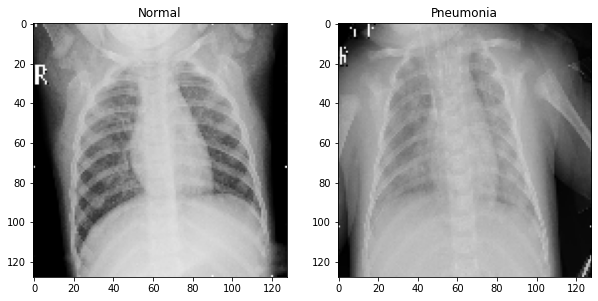

In [15]:
# Plot one image from each list 
# Choose the 1st image from each list
fig = plt.figure(figsize=(10,10))
n = 0

# Normal
ax1 = fig.add_subplot(121)
plt.imshow(X_val[normal_img_num[n]])
print(y_val[normal_img_num[n]])
plt.title("Normal");

# Pneumonia
ax2 = fig.add_subplot(122)
plt.imshow(X_val[pneumonia_img_num[n]])
print(y_val[pneumonia_img_num[n]])
plt.title("Pneumonia");

In [8]:
def visualize_training_results(history):
    '''
    Input: keras history object 
    
    '''
    
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_ylabel('Accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()

In [9]:
def model_evaluation(model):
    '''
    Input: keras model
    
    Append accuracy results
    
    Plot confusion matrix
    '''
    
    train_acc = []
    test_acc = []
    
    # Train loss and accuracy
    result_train = model.evaluate(X_train, y_train)
    print(f'Training Loss:{result_train[0]:.4}')
    print(f'Training Accuracy:{result_train[1]:.4}')
    train_acc.append(round(result_train[1], 4))
    
    # Test loss and accuracy
    result_test = model.evaluate(X_test, y_test)
    print(f'Test Loss:{result_test[0]:.4}')
    print(f'Test Accuracy:{result_test[1]:.4}')
    test_acc.append(round(result_test[1], 4))
    
    # Prediction
    y_test_pred = (model.predict(X_test) > 0.5).astype("int32")
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
    ax.set_ylim(2,0)
    plt.xlabel('Predictions')
    plt.ylabel('Actuals')
    plt.show()
    
    # Classification Report
    print(classification_report(y_test, y_test_pred))
    
    return train_acc, test_acc

### Note:
- Since the <u>*validation set*</u> contains much less data than the <u>*test set*</u>, I will use the <u>*test set*</u> as my validation during the model fit step (for better model tunning)
- <u>*validation set*</u> will be used as true holdout which only use at the end 

#### Problem of small validation set
- If the validation set contains much less data than training set, the validation curves (accuracy and loss) will be spiky before convergence and it will become harder for model tunning

## IV. Modeling

### CNN Baseline Model

In [18]:
base_model = models.Sequential()
base_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
base_model.add(layers.MaxPooling2D((2, 2)))

base_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
base_model.add(layers.MaxPooling2D((2, 2)))

base_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
base_model.add(layers.MaxPooling2D((2, 2)))

base_model.add(layers.Flatten())
base_model.add(layers.Dense(128, activation='relu'))
base_model.add(layers.Dense(1, activation='sigmoid'))

base_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [20]:
base_history = base_model.fit(X_train, y_train,
                              epochs=50,
                              batch_size=32,
                              validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 4s 22ms/step - loss: 0.2399 - accuracy: 0.9059 - val_loss: 0.8515 - val_accuracy: 0.7532
Epoch 2/50
163/163 [==============================] - 3s 21ms/step - loss: 0.0937 - accuracy: 0.9661 - val_loss: 0.6915 - val_accuracy: 0.7853
Epoch 3/50
163/163 [==============================] - 3s 20ms/step - loss: 0.1005 - accuracy: 0.9638 - val_loss: 1.0843 - val_accuracy: 0.7420
Epoch 4/50
163/163 [==============================] - 3s 21ms/step - loss: 0.0730 - accuracy: 0.9751 - val_loss: 1.1311 - val_accuracy: 0.7692
Epoch 5/50
163/163 [==============================] - 3s 21ms/step - loss: 0.0549 - accuracy: 0.9799 - val_loss: 0.8473 - val_accuracy: 0.7997
Epoch 6/50
163/163 [==============================] - 3s 21ms/step - loss: 0.0494 - accuracy: 0.9827 - val_loss: 1.4954 - val_accuracy: 0.7516
Epoch 7/50
163/163 [==============================] - 3s 21ms/step - loss: 0.0328 - accuracy: 0.9883 - val_loss: 1.2002 - val_accuracy: 0.7756

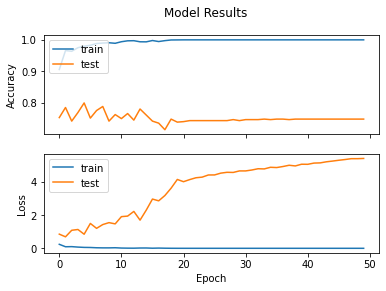

In [21]:
visualize_training_results(base_history)

In [22]:
base_model.save('/content/saved_models/base_model.h5')

163/163 [==============================] - 1s 8ms/step - loss: 1.3827e-06 - accuracy: 1.0000
Training Loss:1.383e-06
Training Accuracy:1.0
20/20 [==============================] - 0s 9ms/step - loss: 5.4036 - accuracy: 0.7484
Test Loss:5.404
Test Accuracy:0.7484


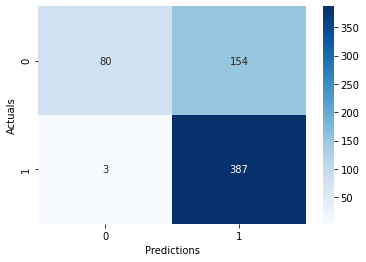

              precision    recall  f1-score   support

         0.0       0.96      0.34      0.50       234
         1.0       0.72      0.99      0.83       390

    accuracy                           0.75       624
   macro avg       0.84      0.67      0.67       624
weighted avg       0.81      0.75      0.71       624



([1.0], [0.7484])

In [23]:
base = load_model('/content/saved_models/base_model.h5')
bm = model_evaluation(base)
bm

#### Comment on *Baseline Model*
- The accuracy plot shows that test accuracy reaches convergence after 20 epochs 
- The loss plot shows that test loss still increase after 20 epochs
    - <b>Early stopping</b> can be used for iteration model tunning to prevent loss


- The train accuracy (100%) is much higher than test accuracy (0.753) which indicates that the baseline model is overfit
    - <b>Regularization</b> techniques can be applied to solve the overfitting issue
        - Dropout, L1, L2, L1+L2


- There are more false positive than false negative. A possible guess would be class imbalance problem because there are more positive (1, pneumonia) case than negative (0, normal) case during the training step
    - <b>Resample</b> techniques
        - class weight, SMOTE

#### Iteration Steps
- Add <b>padding</b> for more accurate analysis
- Add <b> early stopping</b>
- <b>Resample</b> techniques will be applied before <b>Regularization</b> techiniques
- Increase the depth of the CNN
- Backup options: pretrained network

#### Early Stopping

In [17]:
# Early Stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=6)

### Resample

In [25]:
def padding_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=X_train.shape[1:]))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

#### a) balanced weights

https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras

In [14]:
from sklearn.utils.class_weight import compute_class_weight

In [15]:
class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)

# Change to dictionary in oder to work in Keras
weights_dict = dict(zip(np.unique(y_train), class_weights))
weights_dict

{0.0: 1.9448173005219984, 1.0: 0.6730322580645162}

In [29]:
balanced_model = padding_model()

In [30]:
mc_balanced = ModelCheckpoint(filepath='/content/saved_models/balanced_model.h5', 
                              monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [31]:
balanced_history = balanced_model.fit(X_train, y_train,
                                      epochs=50,
                                      batch_size=32,
                                      class_weight=weights_dict,
                                      callbacks=[es, mc_balanced],
                                      validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 5s 24ms/step - loss: 0.4076 - accuracy: 0.7918 - val_loss: 0.6747 - val_accuracy: 0.7997

Epoch 00001: val_accuracy improved from -inf to 0.79968, saving model to /content/saved_models/balanced_model.h5
Epoch 2/50
163/163 [==============================] - 4s 22ms/step - loss: 0.1030 - accuracy: 0.9637 - val_loss: 0.6164 - val_accuracy: 0.8109

Epoch 00002: val_accuracy improved from 0.79968 to 0.81090, saving model to /content/saved_models/balanced_model.h5
Epoch 3/50
163/163 [==============================] - 4s 23ms/step - loss: 0.0825 - accuracy: 0.9702 - val_loss: 1.0335 - val_accuracy: 0.7484

Epoch 00003: val_accuracy did not improve from 0.81090
Epoch 4/50
163/163 [==============================] - 4s 22ms/step - loss: 0.0680 - accuracy: 0.9751 - val_loss: 0.8607 - val_accuracy: 0.7853

Epoch 00004: val_accuracy did not improve from 0.81090
Epoch 5/50
163/163 [==============================] - 4s 22ms/step - loss: 0.0412 - a

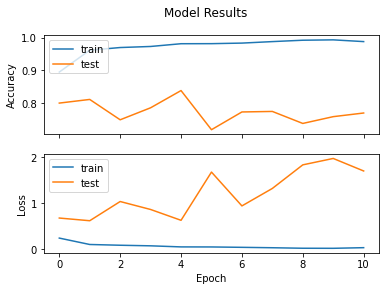

In [32]:
visualize_training_results(balanced_history)

163/163 [==============================] - 1s 8ms/step - loss: 0.0984 - accuracy: 0.9657
Training Loss:0.09845
Training Accuracy:0.9657
20/20 [==============================] - 0s 8ms/step - loss: 0.6256 - accuracy: 0.8381
Test Loss:0.6256
Test Accuracy:0.8381


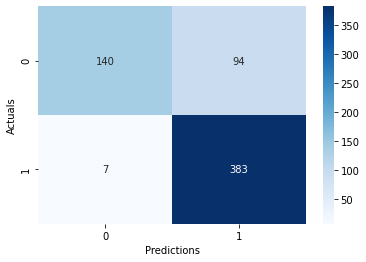

              precision    recall  f1-score   support

         0.0       0.95      0.60      0.73       234
         1.0       0.80      0.98      0.88       390

    accuracy                           0.84       624
   macro avg       0.88      0.79      0.81       624
weighted avg       0.86      0.84      0.83       624



([0.9657], [0.8381])

In [33]:
bal = load_model('/content/saved_models/balanced_model.h5')
bal_m = model_evaluation(bal)
bal_m

#### b) SMOTE
By using SMOTE:
1. Change the 4D array to 2D
2. Transform
3. Change the 2D array back to 4D (otherwise the data wont fit to the shape)

In [34]:
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [35]:
# 4D to 2D
XX_train = X_train.reshape(X_train.shape[0], -1)
yy_train = y_train.reshape(y_train.shape[0], -1)

print(XX_train.shape)
print(yy_train.shape)

(5216, 49152)
(5216, 1)


In [36]:
# SMOTE transform
X_train_resampled, y_train_resampled = SMOTE().fit_resample(XX_train, yy_train)

print(X_train_resampled.shape)
print(y_train_resampled.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(7750, 49152)
(7750,)


In [37]:
# 2D to 4D
XXX_train = X_train_resampled.reshape((7750, 128, 128, 3))
yyy_train = y_train_resampled.reshape((7750,))

print(XXX_train.shape)
print(yyy_train.shape)

(7750, 128, 128, 3)
(7750,)


In [38]:
smote_model = padding_model()

In [39]:
mc_smote = ModelCheckpoint(filepath='/content/saved_models/smote_model.h5', 
                           monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [40]:
smote_history = smote_model.fit(XXX_train, yyy_train,
                                      epochs=50,
                                      batch_size=32,
                                      callbacks=[es, mc_smote],
                                      validation_data=(X_test, y_test))

Epoch 1/50
243/243 [==============================] - 6s 24ms/step - loss: 0.3859 - accuracy: 0.8107 - val_loss: 0.9444 - val_accuracy: 0.7804

Epoch 00001: val_accuracy improved from -inf to 0.78045, saving model to /content/saved_models/smote_model.h5
Epoch 2/50
243/243 [==============================] - 5s 22ms/step - loss: 0.0868 - accuracy: 0.9715 - val_loss: 1.5485 - val_accuracy: 0.6971

Epoch 00002: val_accuracy did not improve from 0.78045
Epoch 3/50
243/243 [==============================] - 5s 22ms/step - loss: 0.0575 - accuracy: 0.9792 - val_loss: 0.9335 - val_accuracy: 0.7981

Epoch 00003: val_accuracy improved from 0.78045 to 0.79808, saving model to /content/saved_models/smote_model.h5
Epoch 4/50
243/243 [==============================] - 5s 22ms/step - loss: 0.0427 - accuracy: 0.9862 - val_loss: 0.8376 - val_accuracy: 0.8237

Epoch 00004: val_accuracy improved from 0.79808 to 0.82372, saving model to /content/saved_models/smote_model.h5
Epoch 5/50
243/243 [=============

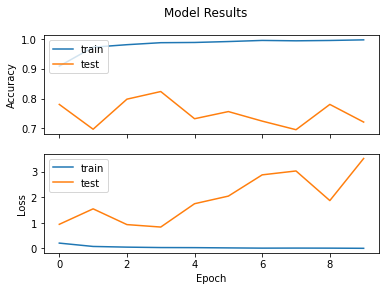

In [41]:
visualize_training_results(smote_history)

163/163 [==============================] - 1s 8ms/step - loss: 0.1007 - accuracy: 0.9655
Training Loss:0.1007
Training Accuracy:0.9655
20/20 [==============================] - 0s 9ms/step - loss: 0.8376 - accuracy: 0.8237
Test Loss:0.8376
Test Accuracy:0.8237


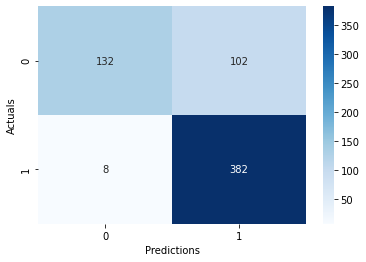

              precision    recall  f1-score   support

         0.0       0.94      0.56      0.71       234
         1.0       0.79      0.98      0.87       390

    accuracy                           0.82       624
   macro avg       0.87      0.77      0.79       624
weighted avg       0.85      0.82      0.81       624



([0.9655], [0.8237])

In [42]:
smo = load_model('/content/saved_models/smote_model.h5')
smo_m = model_evaluation(smo)
smo_m

### 1) Grid Search for dropout %

In [10]:
def dropout_model(percent):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=X_train.shape[1:]))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(percent))

    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(percent))

    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(percent))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

https://faroit.com/keras-docs/1.0.6/scikit-learn-api/

In [11]:
# Wrapper
DP_model = KerasClassifier(build_fn=dropout_model)

In [12]:
# parameter grid
dp_param_grid = {'percent': [0.2, 0.3, 0.4, 0.5]}

DP_grid = GridSearchCV(DP_model, param_grid=dp_param_grid, cv=3)

In [19]:
DP_grid_history = DP_grid.fit(X_train, y_train,
                              epochs=50,
                              batch_size=32,
                              class_weight=weights_dict,
                              callbacks=es,
                              validation_data=(X_test, y_test))

Epoch 1/50
109/109 [==============================] - 4s 31ms/step - loss: 0.7846 - accuracy: 0.6409 - val_loss: 0.4435 - val_accuracy: 0.8173
Epoch 2/50
109/109 [==============================] - 3s 25ms/step - loss: 0.2308 - accuracy: 0.9082 - val_loss: 0.5988 - val_accuracy: 0.8077
Epoch 3/50
109/109 [==============================] - 3s 25ms/step - loss: 0.1468 - accuracy: 0.9497 - val_loss: 0.4336 - val_accuracy: 0.8349
Epoch 4/50
109/109 [==============================] - 3s 25ms/step - loss: 0.1053 - accuracy: 0.9622 - val_loss: 0.8484 - val_accuracy: 0.7901
Epoch 5/50
109/109 [==============================] - 3s 25ms/step - loss: 0.0726 - accuracy: 0.9701 - val_loss: 0.4285 - val_accuracy: 0.8365
Epoch 6/50
109/109 [==============================] - 3s 25ms/step - loss: 0.0919 - accuracy: 0.9662 - val_loss: 1.0248 - val_accuracy: 0.7692
Epoch 7/50
109/109 [==============================] - 3s 25ms/step - loss: 0.0603 - accuracy: 0.9756 - val_loss: 0.7916 - val_accuracy: 0.7981

In [20]:
# Find the best weight_decay value
DP_grid_history.best_params_

{'percent': 0.3}

In [21]:
DP_grid.best_estimator_

In [22]:
model_evaluation(DP_grid.best_estimator_)

AttributeError: ignored

####  Dropout 30

In [23]:
dropout_30 = dropout_model(0.3)

In [24]:
mc_dp_30 = ModelCheckpoint(filepath='/content/saved_models/dropout_30.h5', 
                           monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [25]:
dropout_30_history = dropout_30.fit(X_train, y_train,
                                    epochs=50,
                                    batch_size=32,
                                    class_weight=weights_dict,
                                    callbacks=[es, mc_dp_30],
                                    validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 5s 26ms/step - loss: 0.7941 - accuracy: 0.6693 - val_loss: 0.4388 - val_accuracy: 0.8237

Epoch 00001: val_accuracy improved from -inf to 0.82372, saving model to /content/saved_models/dropout_30.h5
Epoch 2/50
163/163 [==============================] - 4s 25ms/step - loss: 0.1977 - accuracy: 0.9305 - val_loss: 0.4488 - val_accuracy: 0.8429

Epoch 00002: val_accuracy improved from 0.82372 to 0.84295, saving model to /content/saved_models/dropout_30.h5
Epoch 3/50
163/163 [==============================] - 4s 25ms/step - loss: 0.1328 - accuracy: 0.9513 - val_loss: 0.6469 - val_accuracy: 0.7804

Epoch 00003: val_accuracy did not improve from 0.84295
Epoch 4/50
163/163 [==============================] - 4s 25ms/step - loss: 0.1092 - accuracy: 0.9612 - val_loss: 0.5191 - val_accuracy: 0.8157

Epoch 00004: val_accuracy did not improve from 0.84295
Epoch 5/50
163/163 [==============================] - 4s 24ms/step - loss: 0.0934 - accuracy:

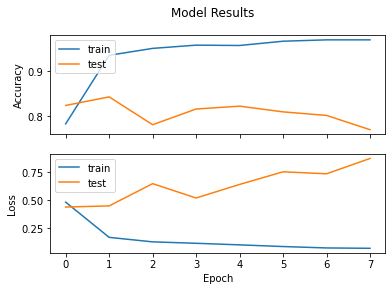

In [27]:
visualize_training_results(dropout_30_history)

163/163 [==============================] - 1s 8ms/step - loss: 0.1232 - accuracy: 0.9548
Training Loss:0.1232
Training Accuracy:0.9548
20/20 [==============================] - 0s 9ms/step - loss: 0.4488 - accuracy: 0.8429
Test Loss:0.4488
Test Accuracy:0.8429


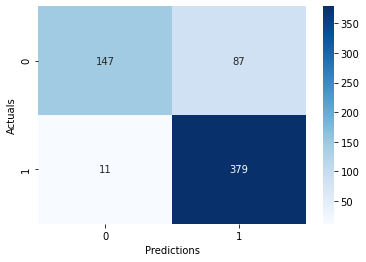

              precision    recall  f1-score   support

         0.0       0.93      0.63      0.75       234
         1.0       0.81      0.97      0.89       390

    accuracy                           0.84       624
   macro avg       0.87      0.80      0.82       624
weighted avg       0.86      0.84      0.83       624



([0.9548], [0.8429])

In [29]:
dp30 = load_model('/content/saved_models/dropout_30.h5')
dp30m = model_evaluation(dp30)
dp30m

>**Comment:** Dropout 20%
- The dropout_20 model took less time to run compare with the baseline model
- The train accuracy (0.9659) is higher than test accuracy (0.7997) which indicates the model is overfit 
- Compare with the baseline model, test accuray shows some improvements
- There are more false positive than false negative
- dp20 has more FN than base

### 2) Grid Search For L2 weight decay

GridSearch https://heartbeat.fritz.ai/introduction-to-deep-learning-with-keras-c7c3d14e1527

In [30]:
def L2_regularizer_model(weight_decay):
    
    # Build the model with L2 regularizer
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), 
                                        activation='relu', input_shape=X_train.shape[1:]))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [31]:
L2_model = KerasClassifier(build_fn=L2_regularizer_model)

In [32]:
# parameter grid
reg_param_grid = {'weight_decay': [0.5, 0.05, 0.005, 0.0005]}

In [33]:
L2_grid = GridSearchCV(L2_model, param_grid=reg_param_grid, cv=3)

In [34]:
L2_grid_history = L2_grid.fit(X_train, y_train,
                              epochs=50,
                              batch_size=32,
                              class_weight=weights_dict,
                              callbacks=es,
                              validation_data=(X_test, y_test))

Epoch 1/50
109/109 [==============================] - 3s 26ms/step - loss: 28.8443 - accuracy: 0.6723 - val_loss: 0.7981 - val_accuracy: 0.8077
Epoch 2/50
109/109 [==============================] - 3s 24ms/step - loss: 0.5123 - accuracy: 0.8997 - val_loss: 0.5115 - val_accuracy: 0.8285
Epoch 3/50
109/109 [==============================] - 3s 24ms/step - loss: 0.3317 - accuracy: 0.9229 - val_loss: 0.4720 - val_accuracy: 0.8285
Epoch 4/50
109/109 [==============================] - 3s 24ms/step - loss: 0.3360 - accuracy: 0.9186 - val_loss: 0.6560 - val_accuracy: 0.7772
Epoch 5/50
109/109 [==============================] - 3s 24ms/step - loss: 0.2835 - accuracy: 0.9382 - val_loss: 0.5276 - val_accuracy: 0.8045
Epoch 6/50
109/109 [==============================] - 3s 24ms/step - loss: 0.2747 - accuracy: 0.9348 - val_loss: 0.8698 - val_accuracy: 0.7099
Epoch 7/50
109/109 [==============================] - 3s 24ms/step - loss: 0.3033 - accuracy: 0.9250 - val_loss: 0.4949 - val_accuracy: 0.815

In [35]:
# Find the best weight_decay value
L2_grid_history.best_params_

{'weight_decay': 0.0005}

#### Regularizer (0.0005)

https://machinelearningmastery.com/weight-regularization-to-reduce-overfitting-of-deep-learning-models/

L2 hyperparameter choosing https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/

In [36]:
L2_reg = L2_regularizer_model(0.0005)

In [37]:
mc_L2_reg = ModelCheckpoint(filepath='/content/saved_models/L2_reg.h5', 
                            monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [38]:
L2_reg_history = L2_reg.fit(X_train, y_train,
                            epochs=50,
                            batch_size=32,
                            class_weight=weights_dict,
                            callbacks=[es, mc_L2_reg],
                            validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 5s 25ms/step - loss: 0.4327 - accuracy: 0.8057 - val_loss: 0.7506 - val_accuracy: 0.7837

Epoch 00001: val_accuracy improved from -inf to 0.78365, saving model to /content/saved_models/L2_reg.h5
Epoch 2/50
163/163 [==============================] - 4s 23ms/step - loss: 0.1414 - accuracy: 0.9659 - val_loss: 0.7580 - val_accuracy: 0.7933

Epoch 00002: val_accuracy improved from 0.78365 to 0.79327, saving model to /content/saved_models/L2_reg.h5
Epoch 3/50
163/163 [==============================] - 4s 24ms/step - loss: 0.1281 - accuracy: 0.9662 - val_loss: 0.9108 - val_accuracy: 0.7676

Epoch 00003: val_accuracy did not improve from 0.79327
Epoch 4/50
163/163 [==============================] - 4s 23ms/step - loss: 0.1058 - accuracy: 0.9750 - val_loss: 0.9280 - val_accuracy: 0.7901

Epoch 00004: val_accuracy did not improve from 0.79327
Epoch 5/50
163/163 [==============================] - 4s 24ms/step - loss: 0.0783 - accuracy: 0.9847 

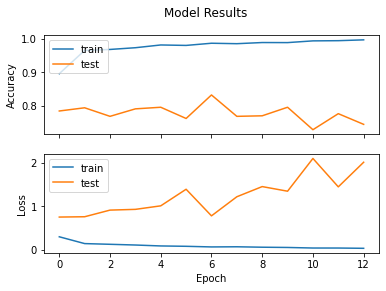

In [39]:
visualize_training_results(L2_reg_history)

163/163 [==============================] - 2s 8ms/step - loss: 0.1150 - accuracy: 0.9705
Training Loss:0.115
Training Accuracy:0.9705
20/20 [==============================] - 0s 9ms/step - loss: 0.7784 - accuracy: 0.8317
Test Loss:0.7784
Test Accuracy:0.8317


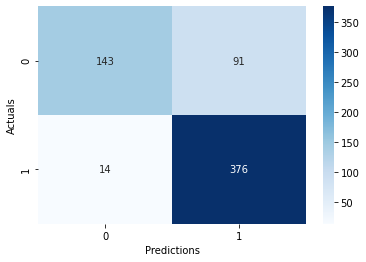

              precision    recall  f1-score   support

         0.0       0.91      0.61      0.73       234
         1.0       0.81      0.96      0.88       390

    accuracy                           0.83       624
   macro avg       0.86      0.79      0.80       624
weighted avg       0.84      0.83      0.82       624



([0.9705], [0.8317])

In [40]:
L2 = load_model('/content/saved_models/L2_reg.h5')
L2m = model_evaluation(L2)
L2m

>**Comment:** 
- The L2 took less time to run compare with the baseline model
- The train accuracy (0.9442) is higher than test accuracy (0.8446) which indicates the model is overfit
- Compare with the baseline model, test accuray shows some improvements
- There are more false positive than false negative

https://datascience.stackexchange.com/questions/77881/whats-the-difference-between-gridsearchcrossvalidation-score-and-score-on-tests#:~:text=Grid%20search%20trains%20different%20models,score%20of%20the%20best%20estimator.&text=It%20means%20that%20the%20model,not%20on%20the%20unseen%20data.

### 3) Grid Search For L1 weight decay

In [41]:
def L1_regularizer_model(weight_decay):
    
    # Build the model with L2 regularizer
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l1(weight_decay), 
                                        activation='relu', input_shape=X_train.shape[1:]))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l1(weight_decay), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l1(weight_decay), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [42]:
L1_model = KerasClassifier(build_fn=L1_regularizer_model)

In [43]:
L1_grid = GridSearchCV(L1_model, param_grid=reg_param_grid, cv=3)

In [44]:
L1_grid_history = L1_grid.fit(X_train, y_train,
                              epochs=50,
                              batch_size=32,
                              class_weight=weights_dict,
                              callbacks=es,
                              validation_data=(X_test, y_test))

Epoch 1/50
109/109 [==============================] - 3s 26ms/step - loss: 723.6553 - accuracy: 0.5668 - val_loss: 8.8216 - val_accuracy: 0.3750
Epoch 2/50
109/109 [==============================] - 3s 24ms/step - loss: 7.2158 - accuracy: 0.2568 - val_loss: 6.4196 - val_accuracy: 0.3750
Epoch 3/50
109/109 [==============================] - 3s 24ms/step - loss: 6.4290 - accuracy: 0.3189 - val_loss: 6.4212 - val_accuracy: 0.3750
Epoch 4/50
109/109 [==============================] - 3s 24ms/step - loss: 6.4324 - accuracy: 0.2578 - val_loss: 6.4472 - val_accuracy: 0.3750
Epoch 5/50
109/109 [==============================] - 3s 24ms/step - loss: 6.4348 - accuracy: 0.2607 - val_loss: 6.4276 - val_accuracy: 0.3750
Epoch 6/50
109/109 [==============================] - 3s 24ms/step - loss: 6.4300 - accuracy: 0.2592 - val_loss: 6.4841 - val_accuracy: 0.3750
Epoch 7/50
109/109 [==============================] - 3s 23ms/step - loss: 6.4432 - accuracy: 0.2658 - val_loss: 6.4091 - val_accuracy: 0.37

In [45]:
# Find the best weight_decay value
L1_grid_history.best_params_

{'weight_decay': 0.0005}

#### L1 Regularizer (0.0005)

In [46]:
L1_reg = L1_regularizer_model(0.0005)

In [47]:
mc_L1_reg = ModelCheckpoint(filepath='/content/saved_models/L1_reg.h5', 
                             monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [48]:
L1_reg_history = L1_reg.fit(X_train, y_train,
                            epochs=50,
                            batch_size=32,
                            class_weight=weights_dict,
                            callbacks=[es, mc_L1_reg],
                            validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 4s 24ms/step - loss: 1.3070 - accuracy: 0.7413 - val_loss: 0.9178 - val_accuracy: 0.7308

Epoch 00001: val_accuracy improved from -inf to 0.73077, saving model to /content/saved_models/L1_reg.h5
Epoch 2/50
163/163 [==============================] - 4s 23ms/step - loss: 0.3767 - accuracy: 0.9554 - val_loss: 0.6022 - val_accuracy: 0.8317

Epoch 00002: val_accuracy improved from 0.73077 to 0.83173, saving model to /content/saved_models/L1_reg.h5
Epoch 3/50
163/163 [==============================] - 4s 23ms/step - loss: 0.2402 - accuracy: 0.9638 - val_loss: 0.7293 - val_accuracy: 0.8045

Epoch 00003: val_accuracy did not improve from 0.83173
Epoch 4/50
163/163 [==============================] - 4s 23ms/step - loss: 0.2131 - accuracy: 0.9620 - val_loss: 0.9119 - val_accuracy: 0.7724

Epoch 00004: val_accuracy did not improve from 0.83173
Epoch 5/50
163/163 [==============================] - 4s 23ms/step - loss: 0.1585 - accuracy: 0.9770 

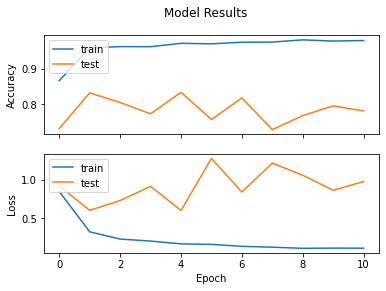

In [49]:
visualize_training_results(L1_reg_history)

163/163 [==============================] - 1s 8ms/step - loss: 0.2530 - accuracy: 0.9398
Training Loss:0.253
Training Accuracy:0.9398
20/20 [==============================] - 0s 8ms/step - loss: 0.6010 - accuracy: 0.8333
Test Loss:0.601
Test Accuracy:0.8333


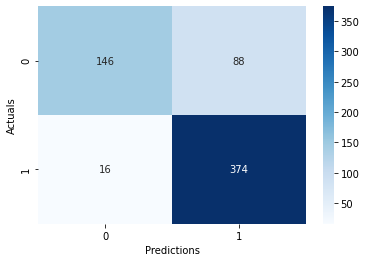

              precision    recall  f1-score   support

         0.0       0.90      0.62      0.74       234
         1.0       0.81      0.96      0.88       390

    accuracy                           0.83       624
   macro avg       0.86      0.79      0.81       624
weighted avg       0.84      0.83      0.83       624



([0.9398], [0.8333])

In [50]:
L1 = load_model('/content/saved_models/L1_reg.h5')
L1m = model_evaluation(L1)
L1m

### 4) L1 + L2

In [52]:
def L1_L2_regularizer_model(wd_1, wd_2):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l1_l2(l1=wd_1, l2=wd_2), 
                        activation='relu', input_shape=(128,128,3)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l1_l2(l1=wd_1, l2=wd_2), 
                        activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l1_l2(l1=wd_1, l2=wd_2), 
                        activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [53]:
L1L2 = L1_L2_regularizer_model(0.0005, 0.0005)

In [54]:
mc_L1L2 = ModelCheckpoint(filepath='/content/saved_models/L1L2.h5', 
                            monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [55]:
L1L2_history = L1L2.fit(X_train, y_train,
                            epochs=50,
                            batch_size=32,
                            class_weight=weights_dict,
                            callbacks=[es, mc_L1L2],
                            validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 5s 25ms/step - loss: 1.2969 - accuracy: 0.8356 - val_loss: 1.1240 - val_accuracy: 0.7580

Epoch 00001: val_accuracy improved from -inf to 0.75801, saving model to /content/saved_models/L1L2.h5
Epoch 2/50
163/163 [==============================] - 4s 23ms/step - loss: 0.3711 - accuracy: 0.9605 - val_loss: 0.8828 - val_accuracy: 0.7516

Epoch 00002: val_accuracy did not improve from 0.75801
Epoch 3/50
163/163 [==============================] - 4s 23ms/step - loss: 0.2853 - accuracy: 0.9567 - val_loss: 0.8705 - val_accuracy: 0.7692

Epoch 00003: val_accuracy improved from 0.75801 to 0.76923, saving model to /content/saved_models/L1L2.h5
Epoch 4/50
163/163 [==============================] - 4s 23ms/step - loss: 0.2175 - accuracy: 0.9635 - val_loss: 0.7583 - val_accuracy: 0.8061

Epoch 00004: val_accuracy improved from 0.76923 to 0.80609, saving model to /content/saved_models/L1L2.h5
Epoch 5/50
163/163 [==============================] - 

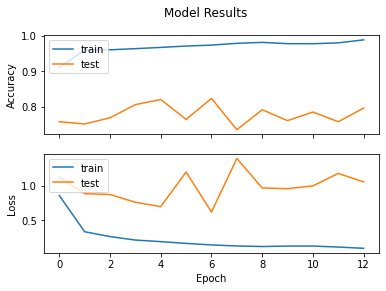

In [56]:
visualize_training_results(L1L2_history)

163/163 [==============================] - 1s 8ms/step - loss: 0.1567 - accuracy: 0.9714
Training Loss:0.1567
Training Accuracy:0.9714
20/20 [==============================] - 0s 9ms/step - loss: 0.6177 - accuracy: 0.8237
Test Loss:0.6177
Test Accuracy:0.8237


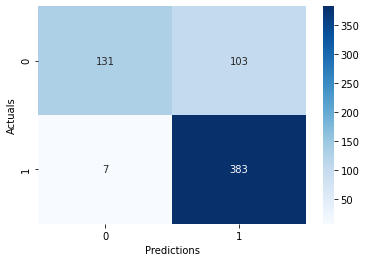

              precision    recall  f1-score   support

         0.0       0.95      0.56      0.70       234
         1.0       0.79      0.98      0.87       390

    accuracy                           0.82       624
   macro avg       0.87      0.77      0.79       624
weighted avg       0.85      0.82      0.81       624



([0.9714], [0.8237])

In [57]:
L1L2_best = load_model('/content/saved_models/L1L2.h5')
L1L2_best_m = model_evaluation(L1L2_best)
L1L2_best_m

### Increase the depth of CNN

### Backup: Pretrained VGG19

In [58]:
from keras.applications import VGG19

In [59]:
pretrained = VGG19(weights='imagenet',
                   include_top=False,
                   input_shape=X_train.shape[1:])

80142336/80134624 [==============================] - 1s 0us/step


In [60]:
pre = models.Sequential()
pre.add(pretrained)
pre.add(layers.Flatten())
pre.add(layers.Dense(128, activation='relu'))
pre.add(layers.Dense(1, activation='sigmoid'))

# Freeze pretained layer
pretrained.trainable = False

In [61]:
pre.summary()

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_44 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_88 (Dense)             (None, 128)               1048704   
_________________________________________________________________
dense_89 (Dense)             (None, 1)                 129       
Total params: 21,073,217
Trainable params: 1,048,833
Non-trainable params: 20,024,384
_________________________________________________________________


In [62]:
# Verify "frozen"
for layer in pre.layers:
    print(layer.name, layer.trainable)

vgg19 False
flatten_44 True
dense_88 True
dense_89 True


In [64]:
pre.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])

In [63]:
mc_pre = ModelCheckpoint(filepath='/content/saved_models/pre.h5', 
                         monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [65]:
pre_history = pre.fit(X_train, y_train,
                      epochs=50,
                      batch_size=32,
                      class_weight=weights_dict,
                      callbacks=[es, mc_pre],
                      validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 14s 64ms/step - loss: 0.3262 - accuracy: 0.8637 - val_loss: 0.6762 - val_accuracy: 0.7869

Epoch 00001: val_accuracy improved from -inf to 0.78686, saving model to /content/saved_models/pre.h5
Epoch 2/50
163/163 [==============================] - 9s 55ms/step - loss: 0.1022 - accuracy: 0.9628 - val_loss: 0.6409 - val_accuracy: 0.8189

Epoch 00002: val_accuracy improved from 0.78686 to 0.81891, saving model to /content/saved_models/pre.h5
Epoch 3/50
163/163 [==============================] - 9s 55ms/step - loss: 0.0675 - accuracy: 0.9756 - val_loss: 0.7163 - val_accuracy: 0.8237

Epoch 00003: val_accuracy improved from 0.81891 to 0.82372, saving model to /content/saved_models/pre.h5
Epoch 4/50
163/163 [==============================] - 9s 56ms/step - loss: 0.0576 - accuracy: 0.9780 - val_loss: 0.6090 - val_accuracy: 0.8462

Epoch 00004: val_accuracy improved from 0.82372 to 0.84615, saving model to /content/saved_models/pre.h5
Epoch 

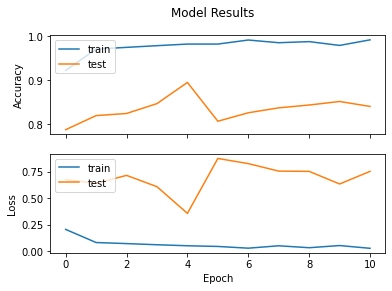

In [66]:
visualize_training_results(pre_history)

163/163 [==============================] - 8s 49ms/step - loss: 0.1894 - accuracy: 0.9289
Training Loss:0.1894
Training Accuracy:0.9289
20/20 [==============================] - 1s 48ms/step - loss: 0.3557 - accuracy: 0.8942
Test Loss:0.3557
Test Accuracy:0.8942


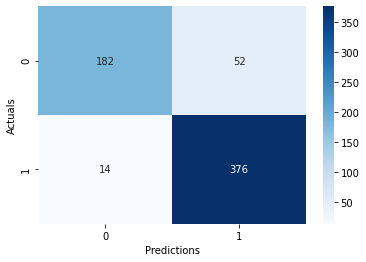

              precision    recall  f1-score   support

         0.0       0.93      0.78      0.85       234
         1.0       0.88      0.96      0.92       390

    accuracy                           0.89       624
   macro avg       0.90      0.87      0.88       624
weighted avg       0.90      0.89      0.89       624



([0.9289], [0.8942])

In [67]:
pret = load_model('/content/saved_models/pre.h5')
PRE = model_evaluation(pret)
PRE

## V. Evaluation

163/163 [==============================] - 8s 48ms/step - loss: 0.1894 - accuracy: 0.9289
Training Loss:0.1894
Training Accuracy:0.9289
20/20 [==============================] - 1s 48ms/step - loss: 0.3557 - accuracy: 0.8942
Test Loss:0.3557
Test Accuracy:0.8942


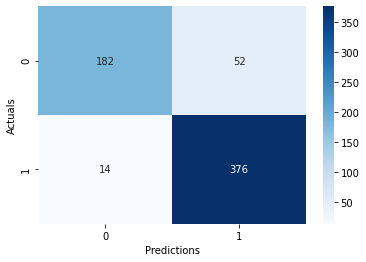

              precision    recall  f1-score   support

         0.0       0.93      0.78      0.85       234
         1.0       0.88      0.96      0.92       390

    accuracy                           0.89       624
   macro avg       0.90      0.87      0.88       624
weighted avg       0.90      0.89      0.89       624



([0.9289], [0.8942])

In [68]:
best = load_model('/content/saved_models/pre.h5')
BEST = model_evaluation(best)
BEST

In [71]:
best.evaluate(X_val, y_val)


1/1 [==============================] - 0s 50ms/step - loss: 0.0785 - accuracy: 0.9375


[0.07847164571285248, 0.9375]

In [72]:
# Predict for probability of getting 1
best.predict(X_val)

# predict_proba was deprecated

array([[0.999788],
       [0.011108],
       [0.836921],
       [0.008234],
       [0.963182],
       [0.00226 ],
       [0.000042],
       [0.981357],
       [0.568236],
       [0.000317],
       [0.998771],
       [0.99918 ],
       [0.000156],
       [0.862494],
       [0.000049],
       [0.991181]], dtype=float32)

In [73]:
# Flatten the array
val_prob = best.predict(X_val).flatten()
val_prob

array([0.999788, 0.011108, 0.836921, 0.008234, 0.963182, 0.00226 ,
       0.000042, 0.981357, 0.568236, 0.000317, 0.998771, 0.99918 ,
       0.000156, 0.862494, 0.000049, 0.991181], dtype=float32)

In [74]:
# Make prediction by using the best model
y_val_pred = ((best.predict(X_val) > 0.5).astype("int32")).flatten()
y_val_pred

# pad.predict_classes(X_val) was deprecated

array([1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1], dtype=int32)

In [75]:
y_val_act = y_val.astype("int32").flatten()
y_val_act

array([1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1], dtype=int32)

In [77]:
compare_val_df = pd.concat([pd.Series(y_val_act, name="Actual"),
                        pd.Series(y_val_pred, name="Predicted"),
                        pd.Series(val_prob, name="Probabilities")], axis=1)

In [78]:
compare_val_df

,Actual,Predicted,Probabilities
0,1,1,0.999788
1,0,0,0.011108
2,1,1,0.836921
3,0,0,0.008234
4,1,1,0.963182
5,0,0,0.002260
6,0,0,0.000042
7,1,1,0.981357
8,0,1,0.568236
9,0,0,0.000317


In [79]:
test_prob = best.predict(X_test).flatten()

In [80]:
y_test_pred = ((best.predict(X_test) > 0.5).astype("int32")).flatten()

In [81]:
y_test_act = y_test.astype("int32").flatten()

In [82]:
compare_test_df = pd.concat([pd.Series(y_test_act, name="Actual"),
                        pd.Series(y_test_pred, name="Predicted"),
                        pd.Series(test_prob, name="Probabilities")], axis=1)

In [83]:
compare_test_df

,Actual,Predicted,Probabilities
0,0,1,0.997201
1,1,1,0.998617
2,1,1,0.974159
3,0,0,0.000048
4,0,0,0.000573
...,...,...,...
619,1,1,0.994787
620,1,1,0.998777
621,1,1,0.998168
622,1,1,0.999907


In [84]:
compare_test_df.to_csv('/content/compare_test_df.csv')

In [85]:
compare_val_df.to_csv('/content/compare_val_df.csv')

#### Visualization

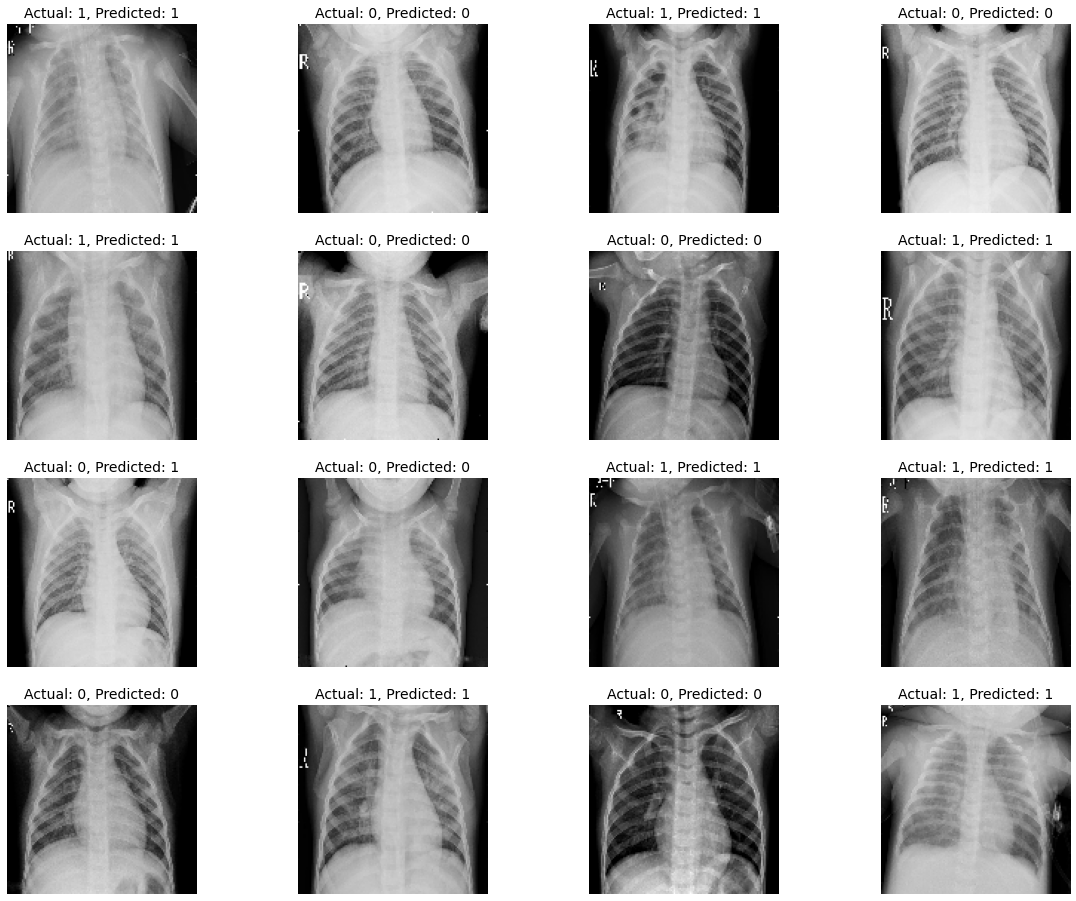

In [86]:
plt.figure(figsize=(20,16))
for i,x in enumerate(X_val):
    plt.subplot(4, 4, i+1)
    plt.imshow(x)
    plt.axis('off')
    plt.title("Actual: {}, Predicted: {}".format(y_val_act[i], y_val_pred[i]), fontsize=14)

    
plt.savefig('val_result.png', dpi=300, bbox_inches='tight')

## VI. Conclusion